In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re
from datetime import datetime
from scipy.sparse import vstack

In [2]:
# Load data
products = pd.read_csv('Products.csv')
products.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,tai bluetooth inpods cảm biến vân chống màu sắ...,dung pin thời gian pin thời gian nhạc liên tục...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,tai bluetooth không dây true wireless dock sạc...,dung pin thời gian pin thời gian nhạc thời gia...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,chuột không dây logitech silent hàng hãng,logitech độ phân giải quang học model lưu kéo ...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...
3,57440329,loa bluetooth kiêm đồng hồ báo thức robot hàng...,acome indonesia trung quốc sku indonesia tình ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...
4,38458616,tai bluetooth apple airpods pro true wireless ...,apple mỹ tai mm hộp sạc mm model tai g hộp sạc...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4370 non-null   int64  
 1   name         4369 non-null   object 
 2   description  4370 non-null   object 
 3   rating       4370 non-null   float64
 4   price        4370 non-null   int64  
 5   list_price   4370 non-null   int64  
 6   brand        4370 non-null   object 
 7   group        4370 non-null   object 
 8   url          4370 non-null   object 
 9   image        4370 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 341.5+ KB


In [4]:
# Concat product_name with description
products['name_description'] = products['name'] + " "+ products['description']
products.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description
0,48102821,tai bluetooth inpods cảm biến vân chống màu sắ...,dung pin thời gian pin thời gian nhạc liên tục...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai bluetooth inpods cảm biến vân chống màu sắ...
1,52333193,tai bluetooth không dây true wireless dock sạc...,dung pin thời gian pin thời gian nhạc thời gia...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai bluetooth không dây true wireless dock sạc...
2,299461,chuột không dây logitech silent hàng hãng,logitech độ phân giải quang học model lưu kéo ...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,chuột không dây logitech silent hàng hãng logi...
3,57440329,loa bluetooth kiêm đồng hồ báo thức robot hàng...,acome indonesia trung quốc sku indonesia tình ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,loa bluetooth kiêm đồng hồ báo thức robot hàng...
4,38458616,tai bluetooth apple airpods pro true wireless ...,apple mỹ tai mm hộp sạc mm model tai g hộp sạc...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai bluetooth apple airpods pro true wireless ...


In [5]:
products.iloc[0]['name_description']

'tai bluetooth inpods cảm biến vân chống màu sắc đa dạng màu sắc lựa dung pin thời gian pin thời gian nhạc liên tục thời gian sạc thời gian chờ bluetooth oem trung quốc độ nhạy cảm biến vân model jack cắm usb cable thời gian sử dụng thời gian nhạc liên tục sku inpod phiên nâng tai bluetooth thiết kế tỉ lệ chuẩn tai airpod hãng lược nút bấm thân tai thay nút cảm ứng sử dụng dàng thuận tiện thao tác nhạc dàng chạm bluetooth kết nối vô ổn định bluetooth kết nối vô ổn định tai kết nối dock sạc chất âm thời pin cải thiện tối ưu dock sạc tiện lợi sạc pin tai thiết tương thích thiết bluetooth xiaomi samsung apple huawei oppo vivo lenovo tablet v v thời gian nhạc liên tục thời gian sạc thời gian chờ'

In [6]:
# Remove Null values in product_name
products = products[products['name_description'].notnull()]

## Cosine Modeling + Evaluation

### Tokenize (split) the sentnces into word

In [7]:
start_time = datetime.now()

In [8]:
products['name_description_wt'] = products['name_description'].apply(lambda x: word_tokenize(x, format='text'))

In [9]:
products.iloc[0]['name_description_wt']

'tai bluetooth inpods_cảm biến_vân chống màu_sắc đa_dạng màu_sắc lựa_dung pin thời_gian pin thời_gian nhạc liên_tục thời_gian sạc thời_gian chờ bluetooth oem trung_quốc độ nhạy_cảm biến_vân model jack cắm usb cable thời_gian sử_dụng thời_gian nhạc liên_tục sku inpod phiên nâng tai_bluetooth thiết_kế tỉ_lệ chuẩn tai_airpod hãng lược nút bấm thân_tai thay nút cảm_ứng sử_dụng_dàng thuận_tiện thao_tác nhạc_dàng chạm bluetooth kết_nối vô ổn_định bluetooth kết_nối vô ổn_định tai kết_nối dock sạc_chất âm_thời pin cải_thiện tối_ưu_dock sạc tiện_lợi sạc pin tai_thiết tương_thích thiết_bluetooth xiaomi samsung apple huawei oppo vivo lenovo tablet v v thời_gian nhạc liên_tục thời_gian sạc thời_gian chờ'

In [10]:
# Reset inđex
products = products.reset_index(drop=True)

In [11]:
# Stop word
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [12]:
tf = TfidfVectorizer(analyzer='word', stop_words=stop_words)

In [13]:
tfidf_matrix = tf.fit_transform(products['name_description_wt'])

In [14]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_similarities

array([[1.        , 0.29149483, 0.0506781 , ..., 0.00536764, 0.00610299,
        0.04086197],
       [0.29149483, 1.        , 0.0547032 , ..., 0.01870259, 0.03214555,
        0.06430043],
       [0.0506781 , 0.0547032 , 1.        , ..., 0.03006766, 0.01132854,
        0.06160534],
       ...,
       [0.00536764, 0.01870259, 0.03006766, ..., 1.        , 0.00399659,
        0.02950918],
       [0.00610299, 0.03214555, 0.01132854, ..., 0.00399659, 1.        ,
        0.02821038],
       [0.04086197, 0.06430043, 0.06160534, ..., 0.02950918, 0.02821038,
        1.        ]])

In [15]:
df_show = pd.DataFrame(cosine_similarities)
df_show.head(9)

,0,1,2,3,4,5,6,7,8,9,...,4359,4360,4361,4362,4363,4364,4365,4366,4367,4368
0,1.000000,0.291495,0.050678,0.131505,0.125576,0.125192,0.112815,0.113714,0.085475,0.031058,...,0.112806,0.021635,0.017392,0.009043,0.056727,0.002969,0.030486,0.005368,0.006103,0.040862
1,0.291495,1.000000,0.054703,0.131745,0.165581,0.131480,0.100827,0.114159,0.090662,0.056964,...,0.138311,0.013223,0.000249,0.015792,0.047671,0.029970,0.038279,0.018703,0.032146,0.064300
2,0.050678,0.054703,1.000000,0.038745,0.058959,0.031475,0.039246,0.019598,0.034073,0.316945,...,0.042230,0.045674,0.008481,0.034696,0.012927,0.044229,0.047784,0.030068,0.011329,0.061605
3,0.131505,0.131745,0.038745,1.000000,0.057524,0.035857,0.022806,0.046320,0.026996,0.025004,...,0.114515,0.016166,0.023732,0.034253,0.105630,0.018482,0.020955,0.026161,0.020407,0.046082
4,0.125576,0.165581,0.058959,0.057524,1.000000,0.453317,0.111945,0.042770,0.131086,0.058155,...,0.057753,0.027715,0.005302,0.022239,0.037619,0.051929,0.051235,0.016660,0.008292,0.061762
5,0.125192,0.131480,0.031475,0.035857,0.453317,1.000000,0.155994,0.037078,0.100317,0.042457,...,0.047386,0.018723,0.001586,0.015956,0.025480,0.027709,0.034938,0.018853,0.010381,0.044042
6,0.112815,0.100827,0.039246,0.022806,0.111945,0.155994,1.000000,0.019417,0.211606,0.055102,...,0.054495,0.019921,0.022101,0.021965,0.048822,0.037382,0.068855,0.017016,0.037514,0.149117
7,0.113714,0.114159,0.019598,0.046320,0.042770,0.037078,0.019417,1.000000,0.015171,0.018264,...,0.036646,0.007760,0.003031,0.003757,0.006834,0.032739,0.017560,0.007543,0.019063,0.056656
8,0.085475,0.090662,0.034073,0.026996,0.131086,0.100317,0.211606,0.015171,1.000000,0.029687,...,0.056473,0.029640,0.020956,0.025507,0.058514,0.025157,0.051517,0.022287,0.009137,0.106628


In [16]:
# df_show.style.applymap(lambda x: "background-color: lightblue" if x>=1.0 else "background-color: green" if x>=0.2 and x<1.0 else "background-color: white")

In [17]:
cosine_similarities.shape

(4369, 4369)

In [18]:
# với mỗi sản phẩm, lấy 10 sản phẩm tương quan nhất
results = {}

for idx in range(len(cosine_similarities)):    
    similar_indices = cosine_similarities[idx].argsort()[-10:-1]
    similar_items = [(cosine_similarities[idx][i], products['item_id'][i]) for i in similar_indices]
    similar_items = sorted(similar_items, key=lambda x: x[0], reverse=True)
    results[products.iloc[idx]['item_id']] = similar_items[1:]

In [19]:
results[299461]

[(0.5959689102446857, 389145),
 (0.5640537766558561, 56930154),
 (0.5258311615131643, 203734),
 (0.5100859201869088, 54665),
 (0.4957760839418135, 74267277),
 (0.4618324855992235, 899588),
 (0.41788677109567407, 515550),
 (0.4174551308243942, 55897)]

In [20]:
end_time = datetime.now()
print('Thời gian để chạy mô hình Cosine:', end_time-start_time)

Thời gian để chạy mô hình Cosine: 0:00:49.141818


### Các sản phẩm có tương quan với product_id = 299461

In [21]:
# Lấy thông tin sản phẩm:
def item(id):
    return products.loc[products['item_id']==id]['name'].to_list()[0].split('-')[0]

# Thông tin sản phẩm gợi ý:
def recommend(item_id, num):
    print("Recommending " +str(num) + " products similar to " + item(item_id) + "...")
    print('* '*40)
    recs = results[item_id][:num]
    for rec in recs:
        print(rec[1])
        print("Recommended: product id: " + str(rec[1]) + ", " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

In [22]:
products.loc[products['item_id'] == 299461]

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description,name_description_wt
2,299461,chuột không dây logitech silent hàng hãng,logitech độ phân giải quang học model lưu kéo ...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,chuột không dây logitech silent hàng hãng logi...,chuột không dây logitech silent hàng hãng logi...


In [23]:
start = datetime.now()
recommend(299461, 5)
end = datetime.now()

Recommending 5 products similar to chuột không dây logitech silent hàng hãng...
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
389145
Recommended: product id: 389145, chuột không dây logitech hàng hãng (score:0.5959689102446857)
56930154
Recommended: product id: 56930154, chuột không dây sạc pin hxsj hàng hãng (score:0.5640537766558561)
203734
Recommended: product id: 203734, chuột không dây logitech hàng hãng (score:0.5258311615131643)
54665
Recommended: product id: 54665, chuột không dây logitech hàng hãng (score:0.5100859201869088)
74267277
Recommended: product id: 74267277, chuột không dây netbox hàng hãng (score:0.4957760839418135)


In [24]:
print('Time taken:', end - start)

Time taken: 0:00:00.002026


In [25]:
indices = pd.Series(products.index, index=products['item_id']).drop_duplicates()
def get_recommendations(item_id, cosine_sim=cosine_similarities):
    idx = indices[item_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    product_indices = [i[0] for i in sim_scores]
    return products[['item_id','name']].iloc[product_indices]

In [26]:
start = datetime.now()
get_recommendations(299461)
end = datetime.now()

In [27]:
print('Time taken:', end - start)

Time taken: 0:00:00.002046


### Các sản phẩm có tương quan với keyword

In [28]:
def Cosine_similarity(new_text):
    global tfidf_matrix
    tfidf_new= tf.transform([new_text])
    cosine_similarities_new = cosine_similarity(tfidf_new, tfidf_matrix)
    
    # với mỗi sản phẩm, lấy 10 sản phẩm tương quan nhất
    results_new = {}

    for idx in range(len(cosine_similarities_new)):    
        similar_indices = cosine_similarities_new[idx].argsort()[-10:-1]
        similar_items = [(cosine_similarities_new[idx][i], products['item_id'][i]) for i in similar_indices]
        similar_items = sorted(similar_items, key=lambda x: x[0], reverse=True)
        results_new[products.iloc[idx]['item_id']] = similar_items[1:]
    return results_new

In [29]:
start = datetime.now()
Cosine_similarity("Sáng da")
end = datetime.now()

In [30]:
print('Time taken:', end - start)

Time taken: 0:00:00.010960


### WordCloud

In [31]:
from wordcloud import WordCloud

In [32]:
def get_product_text(item_id, num):
    rcmd_ids = [r[1] for r in results[item_id]] + [item_id]
    text = (products[products.item_id.isin(rcmd_ids)])
    return ' '.join(text.name + text.description)

In [33]:
wordcloud_text = get_product_text(299461, 5)

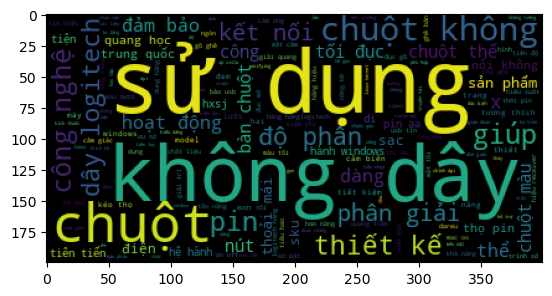

In [34]:
wc = WordCloud(stopwords=stop_words).generate(wordcloud_text)
plt.imshow(wc)

#### Nhận xét chung: 

    - Thời gian chạy mô hình Cosine là 58s
    - Thời gian chạy mô hình Gensim là 1m11s
    
    - Thời gian chạy gợi ý theo product_id của Cosine là 0.002s
    - Thời gian chạy gợi ý theo product_id của Gensim là 0.008s
    
    - Thời gian chạy gợi ý theo keyword của Cosine là 0.01s
    - Thời gian chạy gợi ý theo keyword của Gensim là 0.006s
    
**Gợi ý theo mô hình Gensim với cùng product_id**
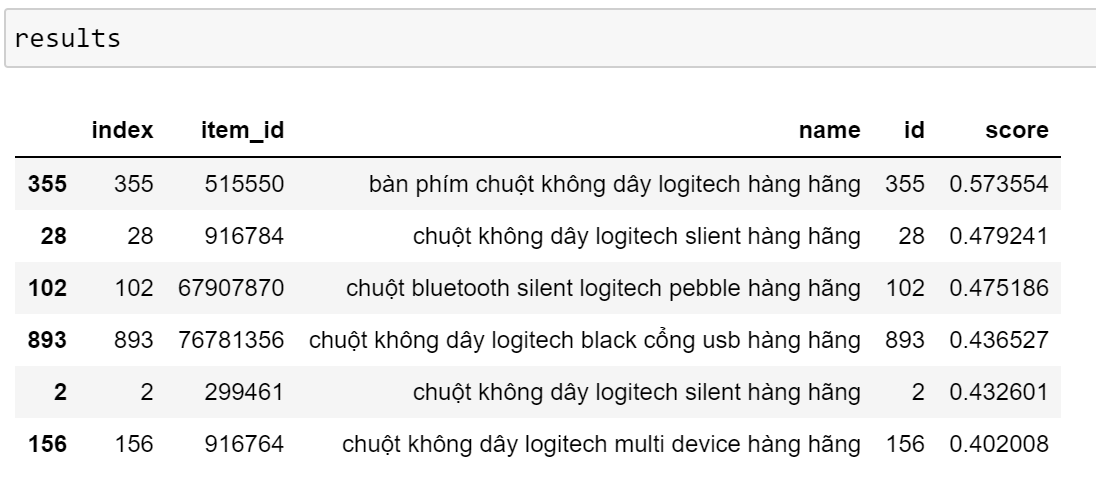
* Có thể thấy score của Gensim cho id này nhỏ hơn score của Cosine
* Vì mỗi mô hình đều có những cách tính toán khác nhau vì vậy, kết quả dự đoán có thể chênh lệch nhau. Công ty cần dựa trên nhu cầu kinh doanh để  lựa chọn mô hình có những đề xuất phù hợp nhất.
* Mô hình Cosine đối với trường hợp gợi ý theo keyword sẽ mất thời gian hơn Gensim rất nhiều vì cần chạy lại matrix.
* Đối với dự án này, chọn mô hình Gensim tối ưu hơn đối với dữ liệu càng lớn.